In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
import os
import re
import math
import pickle
import numpy as np
import scanpy as sc
from collections import Counter
from glob import glob
import pandas as pd
from copy import deepcopy
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, ranksums, chi2_contingency
import matplotlib.pyplot as plt
from pylab import *
from matplotlib import pyplot
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"

In [4]:
PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

In [5]:
def my_vmax(values): 
    return (np.percentile(values, 99)+np.max(values))/2

In [15]:
sns.set_style('ticks')

In [7]:
sc.set_figure_params(fontsize=20)

In [20]:
outdir = '~/decidua/10xVisium/plot/new/atac'

In [8]:
il15_up_genes = list(np.loadtxt('~/decidua/20221002_smart/up_genes.txt', dtype=str))

In [9]:
fosl2_cuttag_anno_df = pd.read_csv('~/decidua/20221123_CUTTag/out/FOSL2_p35.anno.txt', 
                                  sep='\t', index_col=0)
fosl2_target_genes = fosl2_cuttag_anno_df['Gene Name'].unique().tolist()
fosl2_target_genes.remove(np.nan)

In [35]:
il15_up_fosl2_targets = list(set(il15_up_genes) & set(fosl2_target_genes))
unique_fosl2_targets = list(set(fosl2_target_genes)-set(il15_up_genes))
print(len(il15_up_fosl2_targets), len(unique_fosl2_targets))

342 1858


In [36]:
pseudotime_df = pd.read_csv('~/decidua/scATAC/vhg38/new/dNK/file/pseudotime_palantir.csv', 
                            index_col=0)

In [10]:
atac_adata = sc.read_h5ad('~/decidua/scATAC/vhg38/new/dNK/matrix/read_count.h5ad')

In [9]:
# atac_adata.X = csr_matrix(atac_adata.X)

# atac_adata.write('~/decidua/scATAC/vhg38/new/dNK/matrix/read_count.h5ad')

In [16]:
atac_adata = atac_adata[atac_adata.obs['cluster']!='dNK3']
atac_adata.obs['pseudotime'] = pseudotime_df.loc[atac_adata.obs_names,'pseudotime']

/tmp/ipykernel_104865/2240895549.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  atac_adata.obs['pseudotime'] = pseudotime_df.loc[atac_adata.obs_names,'pseudotime']


In [40]:
peak_anno_df = pd.read_csv('~/decidua/scATAC/vhg38/new/dNK/peak/anno_peak.txt', 
                           index_col=0, sep='\t')

In [26]:
atac_adata.var = peak_anno_df

In [34]:
count_df = atac_adata.to_df().T

In [36]:
count_df['Gene Name'] = atac_adata.var['Gene Name'].tolist()

In [39]:
count_df = count_df.groupby('Gene Name').sum()

In [43]:
atac_gene_adata = sc.AnnData(count_df.T)
atac_gene_adata.X = csr_matrix(atac_gene_adata.X)
del count_df

In [46]:
atac_gene_adata.obs = atac_adata.obs

In [49]:
sc.pp.normalize_total(atac_gene_adata, target_sum=1e4)
sc.pp.log1p(atac_gene_adata)

In [57]:
atac_il15_up_fosl2_targets = list(set(il15_up_fosl2_targets) & set(atac_gene_adata.var_names))
atac_unique_fosl2_targets = list(set(unique_fosl2_targets) & set(atac_gene_adata.var_names))

atac_gene_adata.var['class'] = 'Other'
atac_gene_adata.var.loc[atac_il15_up_fosl2_targets,'class'] = 'IL15_up_FOSL2_target'
atac_gene_adata.var.loc[atac_unique_fosl2_targets,'class'] = 'only_FOSL2_target'
atac_gene_adata.var['class'].value_counts()

Other                   19351
only_FOSL2_target        1845
IL15_up_FOSL2_target      341
Name: class, dtype: int64

In [66]:
atac_il15_up_fosl2_targets_df = atac_gene_adata[:,atac_il15_up_fosl2_targets].to_df().mean(axis=1).to_frame()
atac_unique_fosl2_targets_df = atac_gene_adata[:,atac_unique_fosl2_targets].to_df().mean(axis=1).to_frame()
atac_other_df = atac_gene_adata[:,atac_gene_adata.var[atac_gene_adata.var['class']=='Other'].index].to_df().mean(axis=1).to_frame()

In [68]:
atac_il15_up_fosl2_targets_df.columns = ['IL15_up_FOSL2_target']
atac_unique_fosl2_targets_df.columns = ['only_FOSL2_target']
atac_other_df.columns = ['Other']

In [75]:
atac_il15_up_fosl2_targets_df['celltype'] = atac_gene_adata.obs['cluster'].tolist()
atac_unique_fosl2_targets_df['celltype'] = atac_gene_adata.obs['cluster'].tolist()
atac_other_df['celltype'] = atac_gene_adata.obs['cluster'].tolist()

In [76]:
atac_il15_up_fosl2_targets_df['state'] = atac_il15_up_fosl2_targets_df.index.map(lambda x: 'RPL' if x[0]=='P' else 'Ctrl')
atac_unique_fosl2_targets_df['state'] = atac_unique_fosl2_targets_df.index.map(lambda x: 'RPL' if x[0]=='P' else 'Ctrl')
atac_other_df['state'] = atac_other_df.index.map(lambda x: 'RPL' if x[0]=='P' else 'Ctrl')

In [11]:
coverage_dir = '~/decidua/10xVisium/file/new/coverage'
items = ['dNK1_Ctrl','dNK1_RPL','dNK2_Ctrl','dNK2_RPL','dNK3_Ctrl','dNK3_RPL']

In [46]:
fosl2_target_tss_df = pd.read_csv(f'{coverage_dir}/Homo_sapiens.GRCh38.101.TSS.FOSL2_targets.bed', 
                                  sep='\t', names=['chr','start','end','gene'])
fosl2_target_tss_df = fosl2_target_tss_df.drop_duplicates()
fosl2_target_tss_df.index = fosl2_target_tss_df['chr']+':'+fosl2_target_tss_df['start'].map(str)+'-'+fosl2_target_tss_df['end'].map(str)

In [48]:
il15_target_tss_df = pd.read_csv(f'{coverage_dir}/Homo_sapiens.GRCh38.101.TSS.IL15_targets.bed', 
                                  sep='\t', names=['chr','start','end','gene'])
il15_target_tss_df = il15_target_tss_df.drop_duplicates()
il15_target_tss_df.index = il15_target_tss_df['chr']+':'+il15_target_tss_df['start'].map(str)+'-'+il15_target_tss_df['end'].map(str)

In [22]:
# fosl2_target_tss_df = fosl2_target_tss_df[fosl2_target_tss_df.index.value_counts()==1]

/tmp/ipykernel_56594/1130861382.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fosl2_target_tss_df = fosl2_target_tss_df[fosl2_target_tss_df.index.value_counts()==1]


In [24]:
# fosl2_target_tss_df.to_csv(f'{coverage_dir}/Homo_sapiens.GRCh38.101.TSS.FOSL2_targets.bed', 
#                            sep='\t', index=False, header=False)

In [45]:
# gene_tss_df = pd.read_csv(f'{coverage_dir}/Homo_sapiens.GRCh38.101.TSS.bed', 
#                           sep='\t', names=['chr','start','end','gene'])

# il15_gene_tss_df = gene_tss_df[gene_tss_df['gene'].isin(il15_up_genes)]
# il15_gene_tss_df.to_csv(f'{coverage_dir}/Homo_sapiens.GRCh38.101.TSS.IL15_targets.bed', 
#                         sep='\t', index=False, header=False)

# all_gene_tss_df = gene_tss_df[gene_tss_df['gene'].isin(peak_anno_df['Gene Name'])]

# all_gene_tss_df.to_csv(f'{coverage_dir}/Homo_sapiens.GRCh38.101.TSS.scATAC_peak_cover_genes.bed', 
#                        sep='\t', index=False, header=False)

In [64]:
df_ls = []
for item in items:
    df = pd.read_csv(coverage_dir+'/'+item+'.FOSL2_target_genes.coverage.txt', 
                     sep='\t', skiprows=1, header=None)
    df.index = df[3].tolist()
    df = df.loc[list(set(df.index) & set(fosl2_target_tss_df.index))]
    df['gene'] = fosl2_target_tss_df.loc[df.index,'gene']
    df = df.iloc[:,6:].groupby('gene').mean()
    count_mean = df.mean(axis=0)
    coverage_df = (count_mean / count_mean.iloc[0]).to_frame()
    coverage_df.columns = [item]
    df_ls.append(coverage_df)

In [71]:
fosl2_target_concat_df = pd.concat(df_ls, axis=1)

In [92]:
df_ls = []
for item in items:
    df = pd.read_csv(coverage_dir+'/'+item+'.IL15_targets.coverage.txt', 
                     sep='\t', skiprows=1, header=None)
    df.index = df[3].tolist()
    df = df.loc[list(set(df.index) & set(il15_target_tss_df.index))]
    df['gene'] = il15_target_tss_df.loc[df.index,'gene']
    df = df.iloc[:,6:].groupby('gene').mean()
    df = df.loc[list(set(il15_up_fosl2_targets) & set(df.index))]
    count_mean = df.mean(axis=0)
    coverage_df = (count_mean / count_mean.iloc[0]).to_frame()
    coverage_df.columns = [item]
    df_ls.append(coverage_df)

In [93]:
il15_fosl2_target_concat_df = pd.concat(df_ls, axis=1)

In [95]:
all_gene_tss_df = pd.read_csv(f'{coverage_dir}/Homo_sapiens.GRCh38.101.TSS.scATAC_peak_cover_genes.bed', 
                                  sep='\t', names=['chr','start','end','gene'])
all_gene_tss_df = all_gene_tss_df.drop_duplicates()
all_gene_tss_df.index = all_gene_tss_df['chr']+':'+all_gene_tss_df['start'].map(str)+'-'+all_gene_tss_df['end'].map(str)

In [96]:
df_ls = []
for item in items:
    df = pd.read_csv(coverage_dir+'/'+item+'.scATAC_peak_cover_genes.coverage.txt', 
                     sep='\t', skiprows=1, header=None)
    df = pd.read_csv(coverage_dir+'/'+item+'.scATAC_peak_cover_genes.coverage.txt', 
                     sep='\t', skiprows=1, header=None)
    df.index = df[3].tolist()
    df = df.loc[list(set(df.index) & set(all_gene_tss_df.index))]
    df['gene'] = all_gene_tss_df.loc[df.index,'gene']
    df = df.iloc[:,6:].groupby('gene').mean()
    count_mean = df.mean(axis=0)
    coverage_df = (count_mean / count_mean.iloc[0]).to_frame()
    coverage_df.columns = [item]
    df_ls.append(coverage_df)
    
all_gene_concat_df = pd.concat(df_ls, axis=1)

In [102]:
df_ls = []
for item in items:
    df_ls.append(il15_fosl2_target_concat_df[item] / all_gene_concat_df[item])
    
il15_fosl2_target_concat_norm_df = pd.concat(df_ls, axis=1)

In [112]:
fosl2_il15_peak_ls = list(np.loadtxt(coverage_dir+'/FOSL2_binding_IL15_up.peakid.txt', dtype=str))

In [12]:
fosl2_peak_concat_df = pd.read_csv(coverage_dir+'/FOSL2_binding_peaks_IL15_up.coverage_combine.csv', index_col=0)
other_peak_concat_df = pd.read_csv(coverage_dir+'/FOSL2_other_peaks.coverage_combine.csv', index_col=0)

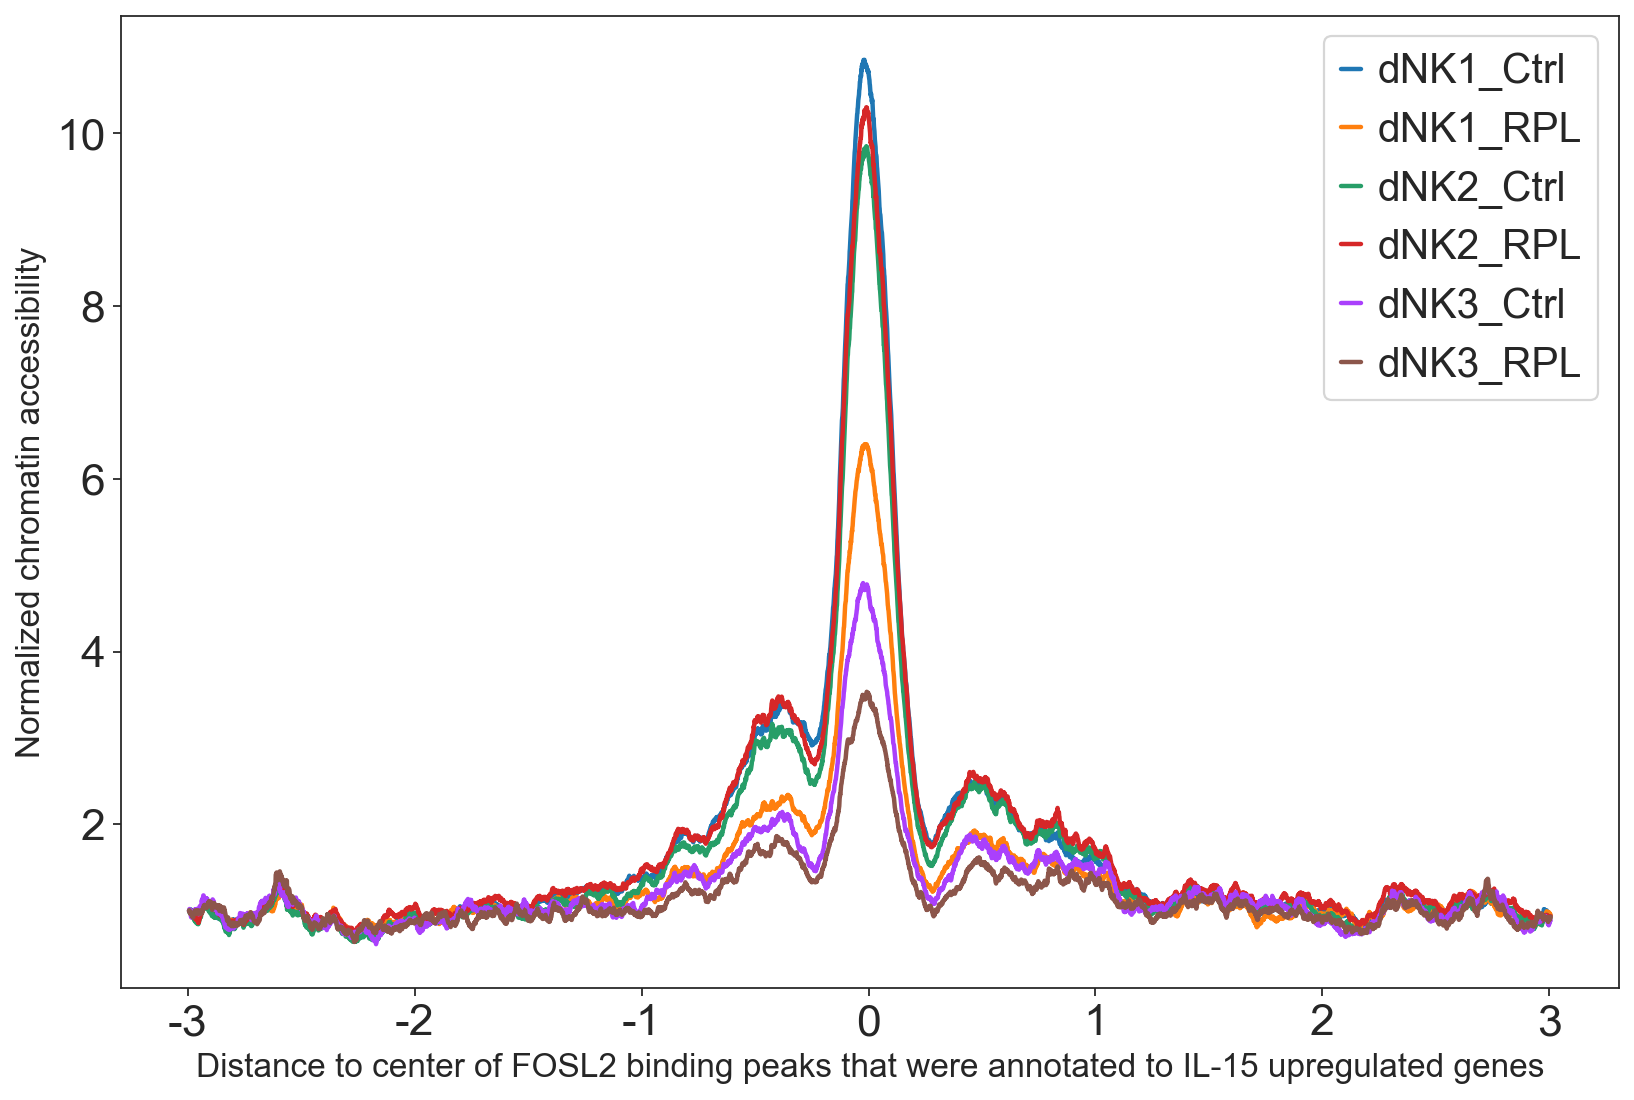

In [17]:
fig = plt.figure(figsize=(12,8))
ax21 = plt.subplot(111)
for item in items:
    ax21.plot(fosl2_peak_concat_df[item], label=item, linewidth=2)
ax21.legend(loc='best')
_ = ax21.set_xlabel('Distance to center of FOSL2 binding peaks that were annotated to IL-15 upregulated genes', fontsize=15)
_ = ax21.set_xticks([0,1000,2000,3000,4000,5000,6000])
_ = ax21.set_xticklabels(['-3','-2','-1','0','1','2','3'])
_ = ax21.set_ylabel('Normalized chromatin accessibility', fontsize=15)